## 2.3 Object detector

In [1]:
import PIL
from PIL import Image, ImageTk
import cv2
from tkinter import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc as msc
from sklearn.metrics import mean_squared_error
import matplotlib.patches as patches
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


The following code slices the image under diagnoses into smaller parts with different shifts in both x and y directions and with different window sizes. The input for the classificator CNN is a 32 x 32 3-channel image. The idea was to start with a 32x32 window and double the size after a segmentation is completed. For one segmentation cycle the window is shifted by one-third of the window size in each iteration in x and y direction separately. The code is also responsible for creating an instruction matrix, which links the input image to the corresponding image position and bounding box size.

In [5]:
def test(img_name, save=False):
    # load model
    model = load_model('Weights/cnn_normalised_weights.hdf5')

    shift = np.array([10,20,40], dtype=np.uint8) #window shifted by number of pixels
    size = np.array([32], dtype=np.uint8) #window sizes in pixels

    uniform_size = 32 #input size of the classificator CNN
    i = 0

    for i_shift, i_size in zip(shift, size): #linking the two jointly changed parameters
        for step_y in range(0,3): #shifting the slicing grid in y direction
            for step_x in range(0,3): #shifting the slicing grid in x direction
                diagimg = np.asarray(PIL.Image.open(img_name)) #reading the currently diagnosed input image
                diagimg = diagimg[i_shift*step_y:, i_shift*step_x:]  #shifting the image according to the corresponding parameters
                grid = diagimg[0:(diagimg.shape[0]//i_size)*i_size, 0:(diagimg.shape[1]//i_size)*i_size] #cropping the image to fit even windows
                grid_sliced = np.asarray(np.split(grid, grid.shape[0]//i_size, axis = 0)) #slicing the image in y direction
                grid_sliced = np.asarray(np.split(grid_sliced, grid_sliced.shape[2]//i_size, axis = 2)) #slicing the image in x direction
                grid_sliced = np.reshape(grid_sliced, (grid_sliced.shape[0]*grid_sliced.shape[1], i_size, i_size, 3)) #reshaping the image into a column array each row containing a sliced window

                vector_x = np.arange(i_shift*step_x, grid.shape[1], i_size) #getting the window positions in x direction
                vector_y = np.arange(i_shift*step_y, grid.shape[0], i_size) #getting the window positions in y direction
                matrix = np.asarray(np.meshgrid(vector_x, vector_y, sparse=False, indexing='ij')) #creating the window position matrix
                info_img = np.transpose(np.reshape(matrix, (2,matrix.shape[1]*matrix.shape[2]))) #reshaping the window position matrix into a column array, each row containing the position of the correspondig sliced window
                info_img = np.concatenate((info_img, np.multiply(i_size,np.ones((info_img.shape[0],1)))), axis=1) #adding the size of the windows to the column array as plus information

                if i_size > uniform_size:
                    out_shape = grid_sliced.shape[0], uniform_size, grid_sliced.shape[1]//uniform_size, uniform_size, grid_sliced.shape[2]//uniform_size, 3 #defining the expected image size for the CNN
                    grid_sliced = grid_sliced.reshape(out_shape).mean(2).mean(3) #resizing the images according to the expected shape for the CNN
                if i==0:
                    input_sequence = grid_sliced
                    info = info_img
                    i += 1
                else:
                    input_sequence = np.append(input_sequence, grid_sliced, axis = 0) #extending the input_sequence with the current new inputs
                    info = np.vstack((info,info_img)) #extending the information array with the current new information
                    i += 1

    info[:, 0], info[:, 1] = info[:, 1], info[:, 0].copy() #changing the order of the x and y positions of the windows

    #input_sequence_scaled = input_sequence/255 #normalizing the input images
    input_sequence_scaled = np.divide(input_sequence, np.sum(input_sequence,3)[:,:,:,None])

    # predict & draw
    preds = model.predict(input_sequence_scaled)
    diagimg = np.asarray(PIL.Image.open(img_name))

    #figure = plt.figure()
    fig, ax = plt.subplots(1,figsize=(25,15))
    ax.imshow(diagimg)
    ax.set_axis_off()
    for i in range(0,preds.shape[0]):
        if preds[i,1] > 0.9 and preds[i,0]<0.1:
            #rect = patches.Rectangle((info[i,1],info[i,0]),info[i,2],info[i,2],linewidth=2,edgecolor='r',facecolor='none')
            #ax.add_patch(rect)
            roi = diagimg[info[i,0].astype(int):info[i,0].astype(int)+info[i,2].astype(int), info[i,1].astype(int):info[i,1].astype(int)+info[i,2].astype(int)]
            roigray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
            #plt.imshow(roigray,cmap='gray')
            #mlp_input = np.zeros(shape=(1,32,32))
            #mlp_input[0] = roigray
            roigrayinput = np.expand_dims(roigray,0)
            roigrayinput = roigrayinput.reshape(roigrayinput.shape[0], -1)
            rect = patches.Rectangle((info[i,1],info[i,0]),info[i,2],info[i,2],linewidth=2,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
                
    if save:
        plt.savefig(img_name[:-4] + '_md' + img_name[-4:])
    plt.show()

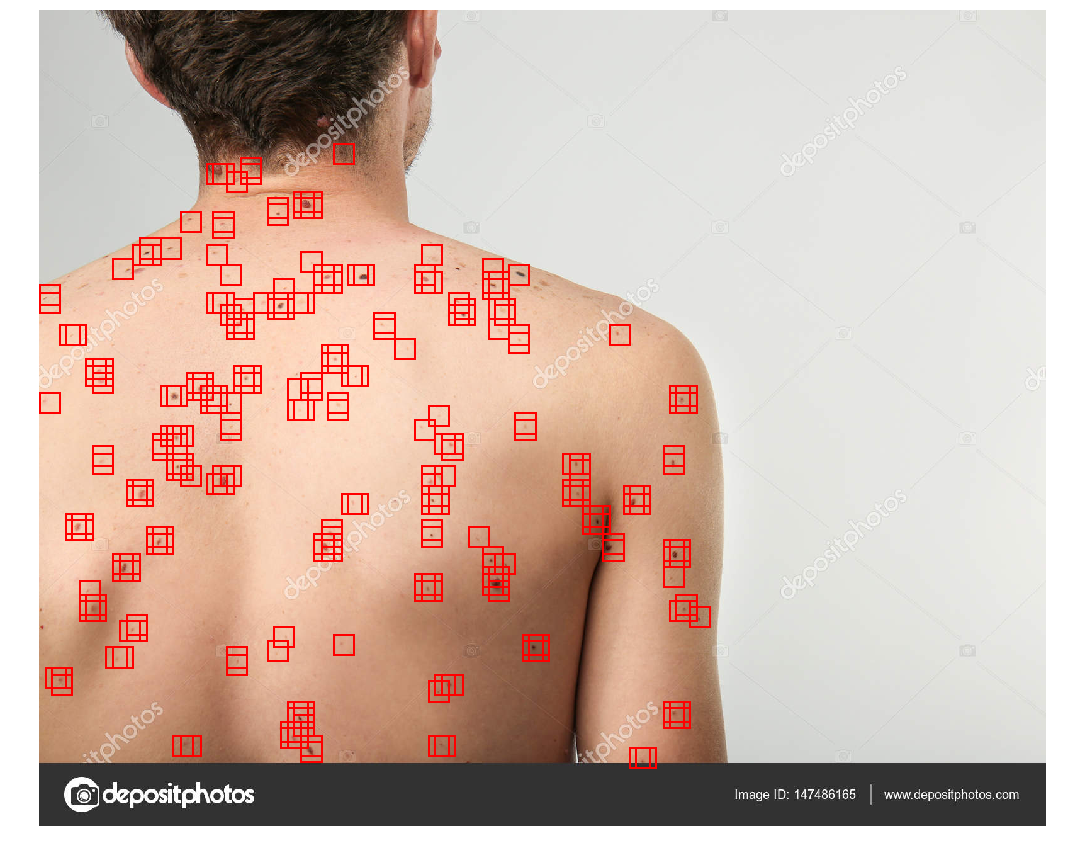

In [4]:
test('Test/3.jpg', save=True)